# EXERCISE 2: CONVOLUTIONAL NEURAL NETWORKS WITH N-GRAM FILTERS
Text Classification with CNNs, Residual Connections, and Self-Attention

In [ ]:
# !pip uninstall -y numpy scipy gensim
# !pip install numpy==1.24.3
# !pip install scipy==1.11.3
# !pip install gensim==4.3.2

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 80.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.7 requires scipy>=1.3.1, which is not installed.
plotnine 0.14.5 requires scipy>=1.8.0, which is not installed.
cvxpy 1.6.5 requires scipy>=1.11.0, which is not installed.
osqp 1.0.4 requires scipy>=0.13.2, which is not installed.
mlxtend 0.23.4 requires scipy>=1.2.1, which is not installed.
pynndescent 0.5.13 requires scipy>=1.0, which is not installed.
hdbscan 0.8.40 requires scipy>=1.0, which is not installed.
clarabel 0.11.0 requires scipy, which is not installed.
librosa 0.11.0 requires scipy>=1.6.0, which

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 19.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.11.3 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━

## Environment Setup & Libraries
Setting up required libraries and checking GPU availability.

In [ ]:
# Core libraries
import os
import io
import string
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Utility data structures
from collections import defaultdict, Counter

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim.downloader as api

# Data preprocessing & evaluation
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, precision_recall_curve, auc
)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Downloading data from the web
import requests
import gzip

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Dataset Loading & Preprocessing
### IMDB Movie Reviews Dataset
Loading the IMDB dataset for binary sentiment classification (50K reviews).

In [ ]:
def download_movie_reviews_dataset():
    print("Downloading IMDB Large Movie Review Dataset...")
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    response = requests.get(url, stream=True)
    compressed_file = io.BytesIO(response.content)

    with gzip.open(compressed_file, 'rb') as f_in:
        with open('aclImdb_v1.tar', 'wb') as f_out:
            f_out.write(f_in.read())

    import tarfile
    with tarfile.open('aclImdb_v1.tar', 'r') as tar:
        tar.extractall()
    os.remove('aclImdb_v1.tar')

    def load_reviews(directory, label):
        reviews = []
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
                    reviews.append((f.read(), label))
        return reviews

    positive_train = load_reviews('aclImdb/train/pos', 'positive')
    negative_train = load_reviews('aclImdb/train/neg', 'negative')
    positive_test = load_reviews('aclImdb/test/pos', 'positive')
    negative_test = load_reviews('aclImdb/test/neg', 'negative')

    all_data = positive_train + negative_train + positive_test + negative_test
    df = pd.DataFrame(all_data, columns=['text', 'sentiment'])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Dataset loaded! Total samples: {len(df)}")
    return df

# Load dataset
df = download_movie_reviews_dataset()

### Data Splitting and Statistics
Splitting into train/test sets and analyzing dataset characteristics.

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['sentiment'])

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Dataset loaded! Total samples: 50000
Training set size: 35000
Test set size: 15000


In [ ]:
def tokenize(data):
    stop_words = stopwords.words('english')
    stop_words.extend(string.punctuation)
    stop_words.extend(["the", "of", "and", "as", "a", "to", "in", "on", "for"])
    tokenized_samples = []
    for sample in data:
        tokens = []
        sentences = sent_tokenize(sample)
        for sent in sentences:
            words = word_tokenize(sent)
            for word in words:
                if '\n' in word or "\t" in word or "--" in word or "*" in word or "@" in word or "#" in word or word.lower() in stop_words:
                    continue
                if word.strip():
                    tokens.append(word.replace('"', "'").strip().lower())
        tokenized_samples.append(tokens)
    return tokenized_samples

### Text Preprocessing Pipeline
- Tokenization using NLTK
- Stopword and punctuation removal  
- Lowercasing and normalization

## Baseline Classifier Implementation
Simple word-sentiment mapping baseline using TF-IDF features for comparison.

In [ ]:
# BASELINE CLASSIFIER (for comparison)
# ====================================================================

class BaselineSentimentClassifier:
    def __init__(self):
        self.word_to_sentiment = {}
        self.most_common_sentiment = None
        self.feature_names = None

    def train(self, X_train, y_train, feature_names=None):
        self.feature_names = feature_names
        sentiment_counts = Counter(y_train)
        self.most_common_sentiment = sentiment_counts.most_common(1)[0][0]

        if self.feature_names is not None:
            for i, feature in enumerate(self.feature_names):
                feature_col = X_train[:, i].toarray().flatten() if hasattr(X_train, 'toarray') else X_train[:, i]
                sentiment_counts = defaultdict(int)
                for sample_idx, value in enumerate(feature_col):
                    if value > 0:
                        sentiment_counts[y_train[sample_idx]] += 1
                if sentiment_counts:
                    self.word_to_sentiment[feature] = max(sentiment_counts.items(), key=lambda x: x[1])[0]

    def predict(self, X_test):
        predictions = []
        if self.feature_names is None:
            return np.full(X_test.shape[0], self.most_common_sentiment)

        for i in range(X_test.shape[0]):
            sample = X_test[i].toarray().flatten() if hasattr(X_test, 'toarray') else X_test[i]
            sample_sentiments = []
            for feature_idx, value in enumerate(sample):
                if value > 0 and self.feature_names[feature_idx] in self.word_to_sentiment:
                    sample_sentiments.append(self.word_to_sentiment[self.feature_names[feature_idx]])

            if sample_sentiments:
                predictions.append(Counter(sample_sentiments).most_common(1)[0][0])
            else:
                predictions.append(self.most_common_sentiment)
        return np.array(predictions)

    def predict_proba(self, X_test):
        predictions = self.predict(X_test)
        n_classes = len(np.unique(predictions))
        probs = np.zeros((X_test.shape[0], n_classes))
        for i, pred in enumerate(predictions):
            probs[i, pred] = 1.0
        return probs

In [ ]:
# Simple preprocessing for baseline
def preprocess_for_baseline(train_data, test_data):
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['sentiment'], test_size=0.3, random_state=42)
    X_test, y_test = test_data['text'], test_data['sentiment']

    unique_labels = pd.concat([y_train, y_val, y_test]).unique()
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    y_train = np.array([label_to_idx[label] for label in y_train], dtype=np.int64)
    y_val = np.array([label_to_idx[label] for label in y_val], dtype=np.int64)
    y_test = np.array([label_to_idx[label] for label in y_test], dtype=np.int64)

    X_train_tokenized = tokenize(X_train)
    X_val_tokenized = tokenize(X_val)
    X_test_tokenized = tokenize(X_test)

    X_train_joined = [" ".join(x) for x in X_train_tokenized]
    X_val_joined = [" ".join(x) for x in X_val_tokenized]
    X_test_joined = [" ".join(x) for x in X_test_tokenized]

    vectorizer = TfidfVectorizer(max_features=2000, sublinear_tf=True)
    X_train = vectorizer.fit_transform(X_train_joined).toarray()
    X_val = vectorizer.transform(X_val_joined).toarray()
    X_test = vectorizer.transform(X_test_joined).toarray()
    feature_names = vectorizer.get_feature_names_out()

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), feature_names, label_to_idx

##  CNN Data Preprocessing
### Sequence Conversion and Padding
Converting text to sequences and preparing data for CNN training.

In [ ]:
# CNN DATA PREPROCESSING AND DATASET
# ====================================================================

def preprocess_data_cnn(train_data, test_data, max_vocab_size=10000, max_seq_len=256):
    X_train, X_val, y_train, y_val = train_test_split(
        train_data['text'], train_data['sentiment'], test_size=0.3, random_state=42)
    X_test, y_test = test_data['text'], test_data['sentiment']

    unique_labels = pd.concat([y_train, y_val, y_test]).unique()
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    y_train = np.array([label_to_idx[label] for label in y_train], dtype=np.int64)
    y_val = np.array([label_to_idx[label] for label in y_val], dtype=np.int64)
    y_test = np.array([label_to_idx[label] for label in y_test], dtype=np.int64)

    # Tokenize texts
    X_train_tokenized = tokenize(X_train)
    X_val_tokenized = tokenize(X_val)
    X_test_tokenized = tokenize(X_test)

    # Build vocabulary from training data
    word_counts = Counter()
    for tokens in X_train_tokenized:
        word_counts.update(tokens)

    most_common_words = word_counts.most_common(max_vocab_size - 2)  # -2 for PAD and UNK
    word_to_idx = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in most_common_words:
        word_to_idx[word] = len(word_to_idx)

    def texts_to_sequences(tokenized_texts):
        sequences = []
        lengths = []
        for tokens in tokenized_texts:
            sequence = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]
            if len(sequence) > max_seq_len:
                sequence = sequence[:max_seq_len]
            sequences.append(sequence)
            lengths.append(len(sequence))
        return sequences, lengths

    X_train_seq, train_lengths = texts_to_sequences(X_train_tokenized)
    X_val_seq, val_lengths = texts_to_sequences(X_val_tokenized)
    X_test_seq, test_lengths = texts_to_sequences(X_test_tokenized)

    # Pad sequences
    def pad_sequences(sequences, max_len):
        padded = []
        for seq in sequences:
            if len(seq) < max_len:
                seq = seq + [0] * (max_len - len(seq))
            padded.append(seq)
        return np.array(padded)

    actual_max_len = min(max(max(train_lengths), max(val_lengths), max(test_lengths)), max_seq_len)

    X_train_padded = pad_sequences(X_train_seq, actual_max_len)
    X_val_padded = pad_sequences(X_val_seq, actual_max_len)
    X_test_padded = pad_sequences(X_test_seq, actual_max_len)

    return ((X_train_padded, y_train, train_lengths),
            (X_val_padded, y_val, val_lengths),
            (X_test_padded, y_test, test_lengths),
            word_to_idx, label_to_idx)

In [ ]:
# Load pre-trained embeddings
def load_pretrained_embeddings(word_to_idx, embedding_dim=300):
    print("Loading pre-trained Word2Vec embeddings...")
    try:
        word_vectors = api.load("word2vec-google-news-300")
        print(f"Loaded {len(word_vectors.key_to_index)} word vectors")
    except:
        print("Using GloVe embeddings as fallback...")
        word_vectors = api.load("glove-wiki-gigaword-300")
        print(f"Loaded {len(word_vectors.key_to_index)} word vectors")

    vocab_size = len(word_to_idx)
    embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embedding_dim))

    # Set PAD token to zeros
    embedding_matrix[0] = np.zeros(embedding_dim)

    # Fill in embeddings for known words
    found_words = 0
    for word, idx in word_to_idx.items():
        if word in word_vectors:
            embedding_matrix[idx] = word_vectors[word]
            found_words += 1

    print(f"Found embeddings for {found_words}/{vocab_size} words")
    return embedding_matrix

### Pre-trained Word Embeddings
Loading Word2Vec/GloVe embeddings to initialize our embedding layer.

## CNN Model Architectures
### Single Filter CNN with Residual Connections
CNN with configurable n-gram filters, residual connections, and max-pooling/attention.

In [ ]:
# CNN MODEL ARCHITECTURES
# ====================================================================

class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, num_filters=100,
                 ngram_kernel_size=3, num_layers=1, use_pooling=True,
                 use_attention=False, attention_dim=64, dropout_rate=0.4,
                 pretrained_embeddings=None, freeze_embeddings=False):
        super(CNNModel, self).__init__()

        self.use_pooling = use_pooling
        self.use_attention = use_attention
        self.dropout_rate = dropout_rate
        self.num_layers = num_layers
        self.ngram_kernel_size = ngram_kernel_size

        assert self.use_pooling or self.use_attention, "Must use either pooling or attention"
        assert not (self.use_pooling and self.use_attention), "Cannot use both pooling and attention"

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        self.dropout = nn.Dropout(dropout_rate)

        # CNN layers with residual connections
        self.conv_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for layer_idx in range(num_layers):
            in_channels = embed_dim if layer_idx == 0 else num_filters

            # Use 'same' padding calculation: padding = (kernel_size - 1) // 2
            padding = (ngram_kernel_size - 1) // 2

            self.conv_layers.append(nn.Conv1d(
                in_channels=in_channels,
                out_channels=num_filters,
                kernel_size=ngram_kernel_size,
                padding=padding,
                stride=1
            ))

            # Add batch normalization for better training
            self.batch_norms.append(nn.BatchNorm1d(num_filters))

        # Projection layer for residual connections when dimensions don't match
        if embed_dim != num_filters:
            self.input_projection = nn.Conv1d(embed_dim, num_filters, kernel_size=1)
        else:
            self.input_projection = None

        # Attention mechanism
        if self.use_attention:
            self.attention_mlp = nn.Sequential(
                nn.Linear(num_filters, attention_dim),
                nn.Tanh(),
                nn.Linear(attention_dim, 1)
            )

        # Global max pooling
        if self.use_pooling:
            self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        # Classification layer
        self.classifier = nn.Linear(num_filters, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        original_seq_len = x.size(1)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        embedded = self.dropout(embedded)

        # Transpose for Conv1d: (batch_size, embed_dim, seq_len)
        z = embedded.transpose(1, 2)

        # Apply convolutional layers with residual connections
        for i, (conv_layer, batch_norm) in enumerate(zip(self.conv_layers, self.batch_norms)):
            # Store input for residual connection
            if i == 0:
                # For first layer, apply projection if needed
                if self.input_projection is not None:
                    residual = self.input_projection(z)
                else:
                    residual = z
            else:
                residual = z

            # Apply convolution
            z = conv_layer(z)
            z = batch_norm(z)
            z = torch.relu(z)

            # Add residual connection (skip connection for first layer in deep networks)
            if i > 0 or self.num_layers == 1:
                # Ensure dimensions match before adding residual
                if z.shape == residual.shape:
                    z = z + residual
                # If dimensions don't match (due to padding), skip residual for safety

        if self.use_pooling:
            # Global max pooling
            pooled = self.global_max_pool(z).squeeze(-1)  # (batch_size, num_filters)
            pooled = self.dropout(pooled)
            return self.classifier(pooled)

        elif self.use_attention:
            # Self-attention mechanism
            z_transposed = z.transpose(1, 2)  # (batch_size, current_seq_len, num_filters)
            current_seq_len = z_transposed.size(1)

            attention_weights = self.attention_mlp(z_transposed)  # (batch_size, current_seq_len, 1)

            # Create padding mask that matches the current sequence length
            # We need to adjust the original padding mask to match the current sequence length
            if current_seq_len <= original_seq_len:
                # Sequence got shorter or stayed same, truncate the mask
                padding_mask = (x[:, :current_seq_len] == 0).unsqueeze(-1).float()
            else:
                # This shouldn't happen with proper padding, but handle it just in case
                padding_mask = torch.zeros(x.size(0), current_seq_len, 1, device=x.device)
                padding_mask[:, :original_seq_len, :] = (x == 0).unsqueeze(-1).float()

            attention_weights = attention_weights.masked_fill(padding_mask.bool(), float('-inf'))

            attention_weights = torch.softmax(attention_weights, dim=1)
            attended = torch.sum(z_transposed * attention_weights, dim=1)  # (batch_size, num_filters)
            attended = self.dropout(attended)
            return self.classifier(attended)

### Multi-Filter CNN Architecture
Advanced CNN combining multiple n-gram filters (2, 3, 4-grams) in parallel.

In [ ]:
class MultiFilterCNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, num_filters=100,
                 num_layers=1, use_pooling=True, use_attention=False,
                 attention_dim=64, dropout_rate=0.4, pretrained_embeddings=None,
                 freeze_embeddings=False):
        super(MultiFilterCNNModel, self).__init__()

        self.use_pooling = use_pooling
        self.use_attention = use_attention
        self.dropout_rate = dropout_rate
        self.num_layers = num_layers

        assert self.use_pooling or self.use_attention, "Must use either pooling or attention"
        assert not (self.use_pooling and self.use_attention), "Cannot use both pooling and attention"

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        self.dropout = nn.Dropout(dropout_rate)

        # Projection layer to match embedding dim with num_filters
        self.embeddings_projection = nn.Linear(embed_dim, num_filters)

        # Multi-filter CNN layers (2-gram, 3-gram, 4-gram)
        self.bigram_layers = nn.ModuleList()
        self.trigram_layers = nn.ModuleList()
        self.fourgram_layers = nn.ModuleList()

        # Batch normalization layers
        self.bigram_bns = nn.ModuleList()
        self.trigram_bns = nn.ModuleList()
        self.fourgram_bns = nn.ModuleList()

        for layer_idx in range(num_layers):
            # Use proper padding calculation for each kernel size to maintain sequence length
            self.bigram_layers.append(nn.Conv1d(
                in_channels=num_filters,
                out_channels=num_filters,
                kernel_size=2,
                padding=1,  # padding = 1 for kernel_size=2 to maintain length
                stride=1
            ))
            self.trigram_layers.append(nn.Conv1d(
                in_channels=num_filters,
                out_channels=num_filters,
                kernel_size=3,
                padding=1,  # padding = 1 for kernel_size=3
                stride=1
            ))
            self.fourgram_layers.append(nn.Conv1d(
                in_channels=num_filters,
                out_channels=num_filters,
                kernel_size=4,
                padding=2,  # padding = 2 for kernel_size=4 to maintain length
                stride=1
            ))

            # Add batch normalization
            self.bigram_bns.append(nn.BatchNorm1d(num_filters))
            self.trigram_bns.append(nn.BatchNorm1d(num_filters))
            self.fourgram_bns.append(nn.BatchNorm1d(num_filters))

        # Attention or pooling
        if self.use_attention:
            self.attention_mlp = nn.Sequential(
                nn.Linear(num_filters * 3, attention_dim),
                nn.Tanh(),
                nn.Linear(attention_dim, 1)
            )

        if self.use_pooling:
            self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        # Classification layer
        self.classifier = nn.Linear(num_filters * 3, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        original_seq_len = x.size(1)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        embedded = self.embeddings_projection(embedded)  # (batch_size, seq_len, num_filters)
        embedded = self.dropout(embedded)

        # Transpose for Conv1d: (batch_size, num_filters, seq_len)
        z = embedded.transpose(1, 2)

        # Apply different n-gram filters with residual connections
        bigram_out = z
        trigram_out = z
        fourgram_out = z

        for layer_idx, (bigram_layer, trigram_layer, fourgram_layer,
                       bigram_bn, trigram_bn, fourgram_bn) in enumerate(
            zip(self.bigram_layers, self.trigram_layers, self.fourgram_layers,
                self.bigram_bns, self.trigram_bns, self.fourgram_bns)):

            # Store residuals
            bigram_residual = bigram_out
            trigram_residual = trigram_out
            fourgram_residual = fourgram_out

            # Apply convolutions
            bigram_out = bigram_layer(bigram_out)
            bigram_out = bigram_bn(bigram_out)
            bigram_out = torch.relu(bigram_out)

            trigram_out = trigram_layer(trigram_out)
            trigram_out = trigram_bn(trigram_out)
            trigram_out = torch.relu(trigram_out)

            fourgram_out = fourgram_layer(fourgram_out)
            fourgram_out = fourgram_bn(fourgram_out)
            fourgram_out = torch.relu(fourgram_out)

            # Trim sequences to match if padding made them longer
            min_len = min(bigram_out.size(2), trigram_out.size(2), fourgram_out.size(2))
            if bigram_out.size(2) > min_len:
                bigram_out = bigram_out[:, :, :min_len]
            if trigram_out.size(2) > min_len:
                trigram_out = trigram_out[:, :, :min_len]
            if fourgram_out.size(2) > min_len:
                fourgram_out = fourgram_out[:, :, :min_len]

            # Also trim residuals to match
            if bigram_residual.size(2) > min_len:
                bigram_residual = bigram_residual[:, :, :min_len]
            if trigram_residual.size(2) > min_len:
                trigram_residual = trigram_residual[:, :, :min_len]
            if fourgram_residual.size(2) > min_len:
                fourgram_residual = fourgram_residual[:, :, :min_len]

            # Add residual connections only if dimensions match
            if layer_idx > 0 or self.num_layers == 1:
                if bigram_out.shape == bigram_residual.shape:
                    bigram_out = bigram_out + bigram_residual
                if trigram_out.shape == trigram_residual.shape:
                    trigram_out = trigram_out + trigram_residual
                if fourgram_out.shape == fourgram_residual.shape:
                    fourgram_out = fourgram_out + fourgram_residual

        if self.use_pooling:
            # Global max pooling for each filter type
            bigram_pooled = self.global_max_pool(bigram_out).squeeze(-1)
            trigram_pooled = self.global_max_pool(trigram_out).squeeze(-1)
            fourgram_pooled = self.global_max_pool(fourgram_out).squeeze(-1)

            # Concatenate all filter outputs
            output = torch.cat([bigram_pooled, trigram_pooled, fourgram_pooled], dim=1)
            output = self.dropout(output)
            return self.classifier(output)

        elif self.use_attention:
            # Apply attention to each filter type
            bigram_transposed = bigram_out.transpose(1, 2)
            trigram_transposed = trigram_out.transpose(1, 2)
            fourgram_transposed = fourgram_out.transpose(1, 2)

            # Ensure all have the same sequence length for concatenation
            min_seq_len = min(bigram_transposed.size(1),
                             trigram_transposed.size(1),
                             fourgram_transposed.size(1))

            bigram_transposed = bigram_transposed[:, :min_seq_len, :]
            trigram_transposed = trigram_transposed[:, :min_seq_len, :]
            fourgram_transposed = fourgram_transposed[:, :min_seq_len, :]

            # Concatenate for attention
            combined = torch.cat([bigram_transposed, trigram_transposed, fourgram_transposed], dim=-1)

            attention_weights = self.attention_mlp(combined)

            # Apply padding mask (adjust for potentially shorter sequence)
            if min_seq_len <= original_seq_len:
                padding_mask = (x[:, :min_seq_len] == 0).unsqueeze(-1).float()
            else:
                padding_mask = torch.zeros(x.size(0), min_seq_len, 1, device=x.device)
                padding_mask[:, :original_seq_len, :] = (x == 0).unsqueeze(-1).float()

            attention_weights = attention_weights.masked_fill(padding_mask.bool(), float('-inf'))

            attention_weights = torch.softmax(attention_weights, dim=1)
            attended = torch.sum(combined * attention_weights, dim=1)
            attended = self.dropout(attended)
            return self.classifier(attended)

## Training & Evaluation Functions
### Metrics Calculation
Comprehensive evaluation metrics including accuracy, F1, and PR-AUC.

In [ ]:
# TRAINING AND EVALUATION FUNCTIONS
# ====================================================================

def calculate_metrics(y_true, y_pred, y_prob):
    n_classes = y_prob.shape[1]
    accuracy = accuracy_score(y_true, y_pred)

    class_metrics = {}
    pr_auc_scores = []
    for i in range(n_classes):
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)
        y_prob_class = y_prob[:, i]

        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, y_prob_class)
        pr_auc = auc(recall_curve, precision_curve)
        pr_auc_scores.append(pr_auc)

        class_metrics[i] = {
            'precision': precision, 'recall': recall, 'f1': f1, 'pr_auc': pr_auc
        }

    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    macro_pr_auc = np.mean(pr_auc_scores)

    return {
        'accuracy': accuracy, 'class_metrics': class_metrics,
        'macro_precision': macro_precision, 'macro_recall': macro_recall,
        'macro_f1': macro_f1, 'macro_pr_auc': macro_pr_auc
    }

In [ ]:
def evaluate_baseline(baseline_model, X_train, y_train, X_val, y_val, X_test, y_test):
    train_preds = baseline_model.predict(X_train)
    val_preds = baseline_model.predict(X_val)
    test_preds = baseline_model.predict(X_test)

    train_probs = baseline_model.predict_proba(X_train)
    val_probs = baseline_model.predict_proba(X_val)
    test_probs = baseline_model.predict_proba(X_test)

    train_metrics = calculate_metrics(y_train, train_preds, train_probs)
    val_metrics = calculate_metrics(y_val, val_preds, val_probs)
    test_metrics = calculate_metrics(y_test, test_preds, test_probs)

    return {'train': train_metrics, 'val': val_metrics, 'test': test_metrics}

###  Training Pipeline
Training with early stopping, gradient clipping, and validation monitoring.

In [ ]:
def train_cnn_model(model, train_loader, val_loader, criterion, optimizer,
                    epochs=15, device='cuda', patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = "best_cnn_sentiment_model.pt"

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Training)")):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Model improved - saving to {best_model_path}")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    return model, train_losses, val_losses

In [ ]:
def get_predictions_and_labels_cnn(model, data_loader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

### Hyperparameter Tuning
Systematic search over model configurations to find optimal parameters.

In [ ]:
def hyperparameter_tuning_cnn(X_train, y_train, X_val, y_val, vocab_size,
                              embedding_matrix, device='cuda', verbose=True):
    param_grid = {
        'model_type': ['single_filter', 'multi_filter'],
        'num_filters': [64, 100],
        'ngram_size': [2, 3, 4],  # Only for single filter models
        'num_layers': [1, 2, 3],
        'pooling_type': ['max_pool', 'attention'],
        'learning_rate': [1e-3, 5e-4],
        'batch_size': [32, 64],
        'dropout': [0.3, 0.4, 0.5],
        'freeze_embeddings': [False, True]
    }

    # Generate parameter combinations (limit for speed)
    all_combinations = []

    # Single filter combinations
    for model_type in ['single_filter']:
        for num_filters in param_grid['num_filters']:
            for ngram_size in param_grid['ngram_size']:
                for num_layers in param_grid['num_layers']:
                    for pooling_type in param_grid['pooling_type']:
                        for lr in param_grid['learning_rate']:
                            for batch_size in param_grid['batch_size']:
                                for dropout in param_grid['dropout']:
                                    for freeze_emb in param_grid['freeze_embeddings']:
                                        all_combinations.append({
                                            'model_type': model_type,
                                            'num_filters': num_filters,
                                            'ngram_size': ngram_size,
                                            'num_layers': num_layers,
                                            'pooling_type': pooling_type,
                                            'learning_rate': lr,
                                            'batch_size': batch_size,
                                            'dropout': dropout,
                                            'freeze_embeddings': freeze_emb
                                        })

    # Multi filter combinations
    for model_type in ['multi_filter']:
        for num_filters in param_grid['num_filters']:
            for num_layers in param_grid['num_layers']:
                for pooling_type in param_grid['pooling_type']:
                    for lr in param_grid['learning_rate']:
                        for batch_size in param_grid['batch_size']:
                            for dropout in param_grid['dropout']:
                                for freeze_emb in param_grid['freeze_embeddings']:
                                    all_combinations.append({
                                        'model_type': model_type,
                                        'num_filters': num_filters,
                                        'num_layers': num_layers,
                                        'pooling_type': pooling_type,
                                        'learning_rate': lr,
                                        'batch_size': batch_size,
                                        'dropout': dropout,
                                        'freeze_embeddings': freeze_emb
                                    })

    # Limit combinations for faster tuning
    import random
    random.seed(42)
    selected_combinations = random.sample(all_combinations, min(12, len(all_combinations)))

    if verbose:
        print(f"Testing {len(selected_combinations)} hyperparameter combinations")

    results = []
    best_val_loss = float('inf')
    best_model = None
    best_params = None

    for params in tqdm(selected_combinations, desc="Hyperparameter Tuning"):
        if verbose:
            print(f"\nTesting parameters: {params}")

        batch_size = params['batch_size']

        # Create data loaders
        train_dataset = TensorDataset(torch.LongTensor(X_train).to(device),
                                     torch.LongTensor(y_train).to(device))
        val_dataset = TensorDataset(torch.LongTensor(X_val).to(device),
                                   torch.LongTensor(y_val).to(device))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        # Create model based on type
        if params['model_type'] == 'single_filter':
            model = CNNModel(
                vocab_size=vocab_size,
                embed_dim=300,
                output_dim=len(np.unique(y_train)),
                num_filters=params['num_filters'],
                ngram_kernel_size=params['ngram_size'],
                num_layers=params['num_layers'],
                use_pooling=(params['pooling_type'] == 'max_pool'),
                use_attention=(params['pooling_type'] == 'attention'),
                attention_dim=64,
                dropout_rate=params['dropout'],
                pretrained_embeddings=embedding_matrix,
                freeze_embeddings=params['freeze_embeddings']
            ).to(device)
        else:  # multi_filter
            model = MultiFilterCNNModel(
                vocab_size=vocab_size,
                embed_dim=300,
                output_dim=len(np.unique(y_train)),
                num_filters=params['num_filters'],
                num_layers=params['num_layers'],
                use_pooling=(params['pooling_type'] == 'max_pool'),
                use_attention=(params['pooling_type'] == 'attention'),
                attention_dim=64,
                dropout_rate=params['dropout'],
                pretrained_embeddings=embedding_matrix,
                freeze_embeddings=params['freeze_embeddings']
            ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Quick training (5 epochs for hyperparameter search)
        val_losses = []
        for epoch in range(5):
            # Training
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    y_pred = model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    val_loss += loss.item() * X_batch.size(0)

            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        final_val_loss = val_losses[-1]
        results.append((params, final_val_loss))

        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_model = copy.deepcopy(model)
            best_params = params
            if verbose:
                print(f"New best model found! Validation loss: {best_val_loss:.5f}")

    results.sort(key=lambda x: x[1])

    if verbose:
        print("\nTop 3 hyperparameter configurations:")
        for i, (params, val_loss) in enumerate(results[:3]):
            print(f"{i+1}. Val Loss: {val_loss:.5f}, Params: {params}")

    return best_model, best_params, results

##  Visualization Functions
Functions for plotting training curves and precision-recall analysis.

In [ ]:
# PLOTTING FUNCTIONS
# ====================================================================

def plot_loss_curves(train_losses, val_losses, title="CNN Model"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linestyle='--')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f'{title.lower().replace(" ", "_")}_loss_curves.png')
    plt.show()

In [ ]:
def plot_precision_recall_curves(train_labels, train_probs, val_labels, val_probs,
                                test_labels, test_probs, n_classes, model_name="CNN"):
    fig, axes = plt.subplots(n_classes, 3, figsize=(18, 5 * n_classes))
    if n_classes == 1:
        axes = axes.reshape(1, 3)

    splits = ['Train', 'Validation', 'Test']
    colors = ['blue', 'green', 'red']

    for class_idx in range(n_classes):
        for split_idx, (split, labels, probs) in enumerate(zip(
            splits, [train_labels, val_labels, test_labels],
            [train_probs, val_probs, test_probs]
        )):
            y_true_binary = (labels == class_idx).astype(int)
            y_prob_class = probs[:, class_idx]

            precision, recall, _ = precision_recall_curve(y_true_binary, y_prob_class)
            pr_auc = auc(recall, precision)

            ax = axes[class_idx, split_idx]
            ax.plot(recall, precision, color=colors[split_idx], lw=2, label=f'PR-AUC: {pr_auc:.4f}')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title(f'Class {class_idx} - {split} PR Curve ({model_name})')
            ax.legend(loc='best')
            ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_precision_recall_curves.png')
    plt.show()

In [ ]:
def plot_multiple_loss_curves(results_dict, title="Model Comparison"):
    plt.figure(figsize=(12, 8))

    for model_name, metrics in results_dict.items():
        if 'train_losses' in metrics and 'val_losses' in metrics:
            plt.plot(metrics['train_losses'], linestyle='--', alpha=0.7, label=f'{model_name} Train')
            plt.plot(metrics['val_losses'], label=f'{model_name} Val')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Training and Validation Loss Comparison')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_comparison.png')
    plt.show()

##  Main Execution & Experiments
###  Baseline Model Training
Training simple baseline classifier for performance comparison.

In [ ]:
# BASELINE COMPARISON
# ====================================================================

print("\n--- Training Baseline Classifier ---")
(X_train_base, y_train_base), (X_val_base, y_val_base), (X_test_base, y_test_base), feature_names, label_to_idx_base = preprocess_for_baseline(train_data, test_data)

baseline_model = BaselineSentimentClassifier()
baseline_model.train(X_train_base, y_train_base, feature_names)
baseline_metrics = evaluate_baseline(baseline_model, X_train_base, y_train_base, X_val_base, y_val_base, X_test_base, y_test_base)

print("=== BASELINE MODEL RESULTS ===")
print(f"Test Accuracy: {baseline_metrics['test']['accuracy']:.4f}")
print(f"Test Macro F1: {baseline_metrics['test']['macro_f1']:.4f}")
print(f"Test Macro PR-AUC: {baseline_metrics['test']['macro_pr_auc']:.4f}")


--- Training Baseline Classifier ---
=== BASELINE MODEL RESULTS ===
Test Accuracy: 0.7815
Test Macro F1: 0.7814
Test Macro PR-AUC: 0.8364


### CNN Data Preparation
Preprocessing data specifically for CNN training with embeddings.

In [ ]:
# CNN MODELS
# ====================================================================

print("\n--- Training CNN Models ---")

# Preprocess data for CNN
((X_train_seq, y_train_cnn, train_lengths),
 (X_val_seq, y_val_cnn, val_lengths),
 (X_test_seq, y_test_cnn, test_lengths),
 word_to_idx, label_to_idx_cnn) = preprocess_data_cnn(train_data, test_data)

print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Max sequence length: {X_train_seq.shape[1]}")
print(f"Training samples: {len(X_train_seq)}")
print(f"Validation samples: {len(X_val_seq)}")
print(f"Test samples: {len(X_test_seq)}")


--- Training CNN Models ---
Vocabulary size: 10000
Max sequence length: 256
Training samples: 24500
Validation samples: 10500
Test samples: 15000


### Hyperparameter Search
Finding optimal CNN configuration through systematic tuning.

Loading pre-trained Word2Vec embeddings...
Loaded 3000000 word vectors
Found embeddings for 9109/10000 words
Average document length (training sample): 129.7 words
Average document length (test sample): 132.7 words

--- Hyperparameter Tuning for CNN ---
Testing 12 hyperparameter combinations


Hyperparameter Tuning:   0%|          | 0/12 [00:00<?, ?it/s]


Testing parameters: {'model_type': 'single_filter', 'num_filters': 64, 'ngram_size': 3, 'num_layers': 2, 'pooling_type': 'attention', 'learning_rate': 0.0005, 'batch_size': 32, 'dropout': 0.3, 'freeze_embeddings': False}


Hyperparameter Tuning:   8%|▊         | 1/12 [00:20<03:44, 20.44s/it]

New best model found! Validation loss: 0.42075

Testing parameters: {'model_type': 'single_filter', 'num_filters': 64, 'ngram_size': 2, 'num_layers': 2, 'pooling_type': 'max_pool', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.4, 'freeze_embeddings': True}


Hyperparameter Tuning:  17%|█▋        | 2/12 [00:34<02:49, 16.96s/it]

New best model found! Validation loss: 0.31976

Testing parameters: {'model_type': 'single_filter', 'num_filters': 100, 'ngram_size': 2, 'num_layers': 3, 'pooling_type': 'attention', 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.5, 'freeze_embeddings': True}


Hyperparameter Tuning:  25%|██▌       | 3/12 [00:52<02:36, 17.40s/it]

New best model found! Validation loss: 0.28707

Testing parameters: {'model_type': 'single_filter', 'num_filters': 100, 'ngram_size': 2, 'num_layers': 2, 'pooling_type': 'max_pool', 'learning_rate': 0.0005, 'batch_size': 64, 'dropout': 0.4, 'freeze_embeddings': True}


Hyperparameter Tuning:  33%|███▎      | 4/12 [01:06<02:06, 15.78s/it]


Testing parameters: {'model_type': 'single_filter', 'num_filters': 100, 'ngram_size': 2, 'num_layers': 1, 'pooling_type': 'attention', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.3, 'freeze_embeddings': True}


Hyperparameter Tuning:  42%|████▏     | 5/12 [01:21<01:50, 15.75s/it]


Testing parameters: {'model_type': 'single_filter', 'num_filters': 64, 'ngram_size': 3, 'num_layers': 3, 'pooling_type': 'attention', 'learning_rate': 0.0005, 'batch_size': 64, 'dropout': 0.4, 'freeze_embeddings': True}


Hyperparameter Tuning:  50%|█████     | 6/12 [01:36<01:32, 15.38s/it]

New best model found! Validation loss: 0.28505

Testing parameters: {'model_type': 'single_filter', 'num_filters': 64, 'ngram_size': 3, 'num_layers': 2, 'pooling_type': 'max_pool', 'learning_rate': 0.0005, 'batch_size': 32, 'dropout': 0.5, 'freeze_embeddings': True}


Hyperparameter Tuning:  58%|█████▊    | 7/12 [01:51<01:16, 15.24s/it]


Testing parameters: {'model_type': 'multi_filter', 'num_filters': 100, 'num_layers': 3, 'pooling_type': 'max_pool', 'learning_rate': 0.0005, 'batch_size': 32, 'dropout': 0.3, 'freeze_embeddings': False}


Hyperparameter Tuning:  67%|██████▋   | 8/12 [02:55<02:03, 30.82s/it]


Testing parameters: {'model_type': 'single_filter', 'num_filters': 64, 'ngram_size': 3, 'num_layers': 1, 'pooling_type': 'attention', 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.5, 'freeze_embeddings': False}


Hyperparameter Tuning:  75%|███████▌  | 9/12 [03:12<01:19, 26.48s/it]


Testing parameters: {'model_type': 'multi_filter', 'num_filters': 64, 'num_layers': 1, 'pooling_type': 'max_pool', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.3, 'freeze_embeddings': False}


Hyperparameter Tuning:  83%|████████▎ | 10/12 [03:34<00:50, 25.08s/it]


Testing parameters: {'model_type': 'single_filter', 'num_filters': 64, 'ngram_size': 2, 'num_layers': 2, 'pooling_type': 'max_pool', 'learning_rate': 0.0005, 'batch_size': 32, 'dropout': 0.5, 'freeze_embeddings': True}


Hyperparameter Tuning:  92%|█████████▏| 11/12 [03:48<00:21, 21.77s/it]


Testing parameters: {'model_type': 'single_filter', 'num_filters': 64, 'ngram_size': 2, 'num_layers': 2, 'pooling_type': 'max_pool', 'learning_rate': 0.0005, 'batch_size': 32, 'dropout': 0.3, 'freeze_embeddings': True}


Hyperparameter Tuning: 100%|██████████| 12/12 [04:03<00:00, 20.30s/it]



Top 3 hyperparameter configurations:
1. Val Loss: 0.28505, Params: {'model_type': 'single_filter', 'num_filters': 64, 'ngram_size': 3, 'num_layers': 3, 'pooling_type': 'attention', 'learning_rate': 0.0005, 'batch_size': 64, 'dropout': 0.4, 'freeze_embeddings': True}
2. Val Loss: 0.28707, Params: {'model_type': 'single_filter', 'num_filters': 100, 'ngram_size': 2, 'num_layers': 3, 'pooling_type': 'attention', 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.5, 'freeze_embeddings': True}
3. Val Loss: 0.30878, Params: {'model_type': 'single_filter', 'num_filters': 100, 'ngram_size': 2, 'num_layers': 1, 'pooling_type': 'attention', 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.3, 'freeze_embeddings': True}

Best CNN parameters: {'model_type': 'single_filter', 'num_filters': 64, 'ngram_size': 3, 'num_layers': 3, 'pooling_type': 'attention', 'learning_rate': 0.0005, 'batch_size': 64, 'dropout': 0.4, 'freeze_embeddings': True}

--- Final CNN Training ---


Epoch 1/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 323.18it/s]


Epoch 1/20 - Train Loss: 0.28951, Val Loss: 0.27883
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 2/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 326.40it/s]


Epoch 2/20 - Train Loss: 0.27801, Val Loss: 0.28194
Patience: 1/7


Epoch 3/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 326.54it/s]


Epoch 3/20 - Train Loss: 0.26508, Val Loss: 0.31411
Patience: 2/7


Epoch 4/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 322.05it/s]


Epoch 4/20 - Train Loss: 0.25950, Val Loss: 0.27654
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 5/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 327.21it/s]


Epoch 5/20 - Train Loss: 0.25450, Val Loss: 0.30907
Patience: 1/7


Epoch 6/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 325.77it/s]


Epoch 6/20 - Train Loss: 0.25173, Val Loss: 0.30192
Patience: 2/7


Epoch 7/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 328.30it/s]


Epoch 7/20 - Train Loss: 0.24246, Val Loss: 0.28209
Patience: 3/7


Epoch 8/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 328.17it/s]


Epoch 8/20 - Train Loss: 0.23122, Val Loss: 0.30508
Patience: 4/7


Epoch 9/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 330.97it/s]


Epoch 9/20 - Train Loss: 0.23059, Val Loss: 0.29049
Patience: 5/7


Epoch 10/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 329.57it/s]


Epoch 10/20 - Train Loss: 0.22780, Val Loss: 0.28210
Patience: 6/7


Epoch 11/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 313.13it/s]


Epoch 11/20 - Train Loss: 0.22400, Val Loss: 0.27499
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 12/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 328.35it/s]


Epoch 12/20 - Train Loss: 0.21672, Val Loss: 0.30280
Patience: 1/7


Epoch 13/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 328.34it/s]


Epoch 13/20 - Train Loss: 0.21363, Val Loss: 0.27451
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 14/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 330.22it/s]


Epoch 14/20 - Train Loss: 0.20716, Val Loss: 0.29576
Patience: 1/7


Epoch 15/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 301.40it/s]


Epoch 15/20 - Train Loss: 0.20266, Val Loss: 0.28820
Patience: 2/7


Epoch 16/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 326.88it/s]


Epoch 16/20 - Train Loss: 0.19842, Val Loss: 0.29411
Patience: 3/7


Epoch 17/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 328.59it/s]


Epoch 17/20 - Train Loss: 0.19349, Val Loss: 0.29880
Patience: 4/7


Epoch 18/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 326.82it/s]


Epoch 18/20 - Train Loss: 0.18591, Val Loss: 0.29646
Patience: 5/7


Epoch 19/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 290.99it/s]


Epoch 19/20 - Train Loss: 0.18866, Val Loss: 0.31593
Patience: 6/7


Epoch 20/20 (Validation): 100%|██████████| 165/165 [00:00<00:00, 326.73it/s]


Epoch 20/20 - Train Loss: 0.18535, Val Loss: 0.29472
Patience: 7/7
Early stopping after 20 epochs


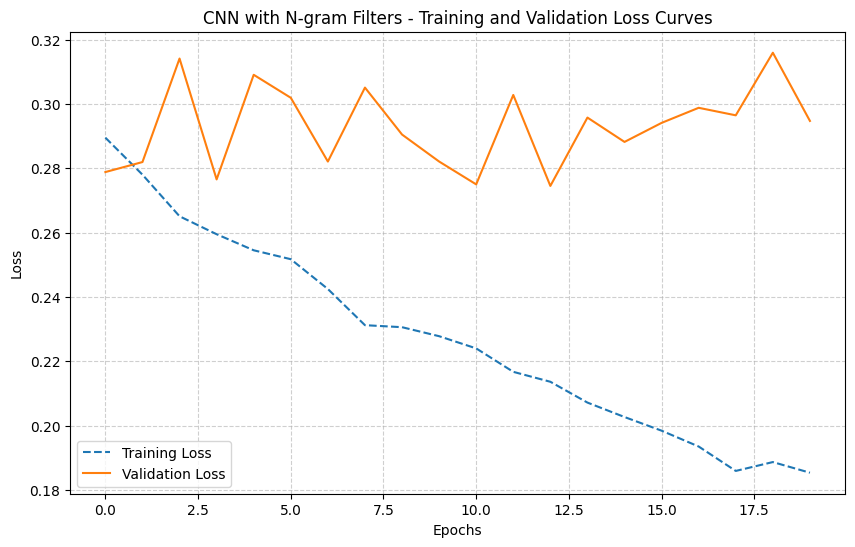

In [ ]:
# Load pre-trained embeddings
embedding_matrix = load_pretrained_embeddings(word_to_idx, embedding_dim=300)

# Calculate dataset statistics
avg_train_length = np.mean([len(tokenize([text])[0]) for text in train_data['text'][:1000]])
avg_test_length = np.mean([len(tokenize([text])[0]) for text in test_data['text'][:1000]])

print(f"Average document length (training sample): {avg_train_length:.1f} words")
print(f"Average document length (test sample): {avg_test_length:.1f} words")

# Hyperparameter tuning
print("\n--- Hyperparameter Tuning for CNN ---")
best_cnn_model, best_cnn_params, cnn_tuning_results = hyperparameter_tuning_cnn(
    X_train_seq, y_train_cnn, X_val_seq, y_val_cnn,
    vocab_size=len(word_to_idx),
    embedding_matrix=embedding_matrix,
    device=device,
    verbose=True
)

print(f"\nBest CNN parameters: {best_cnn_params}")

# Prepare data loaders with best parameters
batch_size_cnn = best_cnn_params['batch_size']

train_dataset_cnn = TensorDataset(torch.LongTensor(X_train_seq).to(device),
                                 torch.LongTensor(y_train_cnn).to(device))
val_dataset_cnn = TensorDataset(torch.LongTensor(X_val_seq).to(device),
                               torch.LongTensor(y_val_cnn).to(device))
test_dataset_cnn = TensorDataset(torch.LongTensor(X_test_seq).to(device),
                                torch.LongTensor(y_test_cnn).to(device))

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size_cnn, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size_cnn)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=batch_size_cnn)

# Final training
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(best_cnn_model.parameters(), lr=best_cnn_params['learning_rate'])

print("\n--- Final CNN Training ---")
cnn_model, cnn_train_losses, cnn_val_losses = train_cnn_model(
    model=best_cnn_model,
    train_loader=train_loader_cnn,
    val_loader=val_loader_cnn,
    criterion=criterion_cnn,
    optimizer=optimizer_cnn,
    epochs=20,
    device=device,
    patience=7
)

# Plot loss curves
plot_loss_curves(cnn_train_losses, cnn_val_losses, title="CNN with N-gram Filters")

### CNN Architecture Comparison
Training multiple CNN variants to compare different design choices.

In [ ]:
# TRAIN MULTIPLE CNN VARIANTS FOR COMPARISON
# ====================================================================

print("\n--- Training Multiple CNN Variants ---")

# Define different CNN architectures to compare
cnn_models = {
    'CNN_Bigram_MaxPool': CNNModel(
        vocab_size=len(word_to_idx), embed_dim=300, output_dim=2,
        num_filters=100, ngram_kernel_size=2, num_layers=3,
        use_pooling=True, use_attention=False, dropout_rate=0.4,
        pretrained_embeddings=embedding_matrix, freeze_embeddings=False
    ),
    'CNN_Trigram_MaxPool': CNNModel(
        vocab_size=len(word_to_idx), embed_dim=300, output_dim=2,
        num_filters=100, ngram_kernel_size=3, num_layers=3,
        use_pooling=True, use_attention=False, dropout_rate=0.4,
        pretrained_embeddings=embedding_matrix, freeze_embeddings=False
    ),
    'CNN_Trigram_Attention': CNNModel(
        vocab_size=len(word_to_idx), embed_dim=300, output_dim=2,
        num_filters=100, ngram_kernel_size=3, num_layers=2,
        use_pooling=False, use_attention=True, attention_dim=64, dropout_rate=0.4,
        pretrained_embeddings=embedding_matrix, freeze_embeddings=False
    ),
    'CNN_MultiFilter_MaxPool': MultiFilterCNNModel(
        vocab_size=len(word_to_idx), embed_dim=300, output_dim=2,
        num_filters=100, num_layers=1,
        use_pooling=True, use_attention=False, dropout_rate=0.4,
        pretrained_embeddings=embedding_matrix, freeze_embeddings=False
    ),
    'CNN_MultiFilter_Attention': MultiFilterCNNModel(
        vocab_size=len(word_to_idx), embed_dim=300, output_dim=2,
        num_filters=100, num_layers=1,
        use_pooling=False, use_attention=True, attention_dim=64, dropout_rate=0.4,
        pretrained_embeddings=embedding_matrix, freeze_embeddings=False
    )
}


--- Training Multiple CNN Variants ---



Training CNN_Bigram_MaxPool...


Epoch 1/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 287.04it/s]


Epoch 1/15 - Train Loss: 0.51347, Val Loss: 0.32503
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 2/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 298.23it/s]


Epoch 2/15 - Train Loss: 0.35222, Val Loss: 0.30027
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 3/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 294.32it/s]


Epoch 3/15 - Train Loss: 0.29114, Val Loss: 0.31465
Patience: 1/5


Epoch 4/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 290.82it/s]


Epoch 4/15 - Train Loss: 0.24179, Val Loss: 0.31733
Patience: 2/5


Epoch 5/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 290.81it/s]


Epoch 5/15 - Train Loss: 0.19711, Val Loss: 0.33040
Patience: 3/5


Epoch 6/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 289.81it/s]


Epoch 6/15 - Train Loss: 0.16289, Val Loss: 0.35564
Patience: 4/5


Epoch 7/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 276.84it/s]


Epoch 7/15 - Train Loss: 0.13519, Val Loss: 0.39704
Patience: 5/5
Early stopping after 7 epochs

Training CNN_Trigram_MaxPool...


Epoch 1/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 246.44it/s]


Epoch 1/15 - Train Loss: 0.56507, Val Loss: 0.37769
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 2/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 247.63it/s]


Epoch 2/15 - Train Loss: 0.35213, Val Loss: 0.31308
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 3/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 250.70it/s]


Epoch 3/15 - Train Loss: 0.28715, Val Loss: 0.30022
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 4/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 251.07it/s]


Epoch 4/15 - Train Loss: 0.23955, Val Loss: 0.30678
Patience: 1/5


Epoch 5/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 253.37it/s]


Epoch 5/15 - Train Loss: 0.19650, Val Loss: 0.34189
Patience: 2/5


Epoch 6/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 255.78it/s]


Epoch 6/15 - Train Loss: 0.16362, Val Loss: 0.37469
Patience: 3/5


Epoch 7/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 233.51it/s]


Epoch 7/15 - Train Loss: 0.13149, Val Loss: 0.41330
Patience: 4/5


Epoch 8/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 253.32it/s]


Epoch 8/15 - Train Loss: 0.10287, Val Loss: 0.52346
Patience: 5/5
Early stopping after 8 epochs

Training CNN_Trigram_Attention...


Epoch 1/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 286.18it/s]


Epoch 1/15 - Train Loss: 0.34762, Val Loss: 0.26023
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 2/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 283.99it/s]


Epoch 2/15 - Train Loss: 0.23839, Val Loss: 0.26153
Patience: 1/5


Epoch 3/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 285.71it/s]


Epoch 3/15 - Train Loss: 0.18158, Val Loss: 0.28355
Patience: 2/5


Epoch 4/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 263.09it/s]


Epoch 4/15 - Train Loss: 0.13465, Val Loss: 0.31995
Patience: 3/5


Epoch 5/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 281.08it/s]


Epoch 5/15 - Train Loss: 0.10438, Val Loss: 0.40867
Patience: 4/5


Epoch 6/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 281.68it/s]


Epoch 6/15 - Train Loss: 0.07843, Val Loss: 0.39375
Patience: 5/5
Early stopping after 6 epochs

Training CNN_MultiFilter_MaxPool...


Epoch 1/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 264.23it/s]


Epoch 1/15 - Train Loss: 0.49560, Val Loss: 0.30987
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 2/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 263.18it/s]


Epoch 2/15 - Train Loss: 0.31911, Val Loss: 0.29835
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 3/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 242.15it/s]


Epoch 3/15 - Train Loss: 0.27422, Val Loss: 0.31046
Patience: 1/5


Epoch 4/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 265.91it/s]


Epoch 4/15 - Train Loss: 0.23403, Val Loss: 0.32765
Patience: 2/5


Epoch 5/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 256.25it/s]


Epoch 5/15 - Train Loss: 0.19978, Val Loss: 0.34127
Patience: 3/5


Epoch 6/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 265.15it/s]


Epoch 6/15 - Train Loss: 0.17302, Val Loss: 0.39712
Patience: 4/5


Epoch 7/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 266.47it/s]


Epoch 7/15 - Train Loss: 0.15304, Val Loss: 0.42589
Patience: 5/5
Early stopping after 7 epochs

Training CNN_MultiFilter_Attention...


Epoch 1/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 249.38it/s]


Epoch 1/15 - Train Loss: 0.32466, Val Loss: 0.26457
Model improved - saving to best_cnn_sentiment_model.pt


Epoch 2/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 248.71it/s]


Epoch 2/15 - Train Loss: 0.21378, Val Loss: 0.30104
Patience: 1/5


Epoch 3/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 249.55it/s]


Epoch 3/15 - Train Loss: 0.15753, Val Loss: 0.32672
Patience: 2/5


Epoch 4/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 250.07it/s]


Epoch 4/15 - Train Loss: 0.10870, Val Loss: 0.42243
Patience: 3/5


Epoch 5/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 249.67it/s]


Epoch 5/15 - Train Loss: 0.07645, Val Loss: 0.50223
Patience: 4/5


Epoch 6/15 (Validation): 100%|██████████| 165/165 [00:00<00:00, 246.86it/s]


Epoch 6/15 - Train Loss: 0.05679, Val Loss: 0.51231
Patience: 5/5
Early stopping after 6 epochs


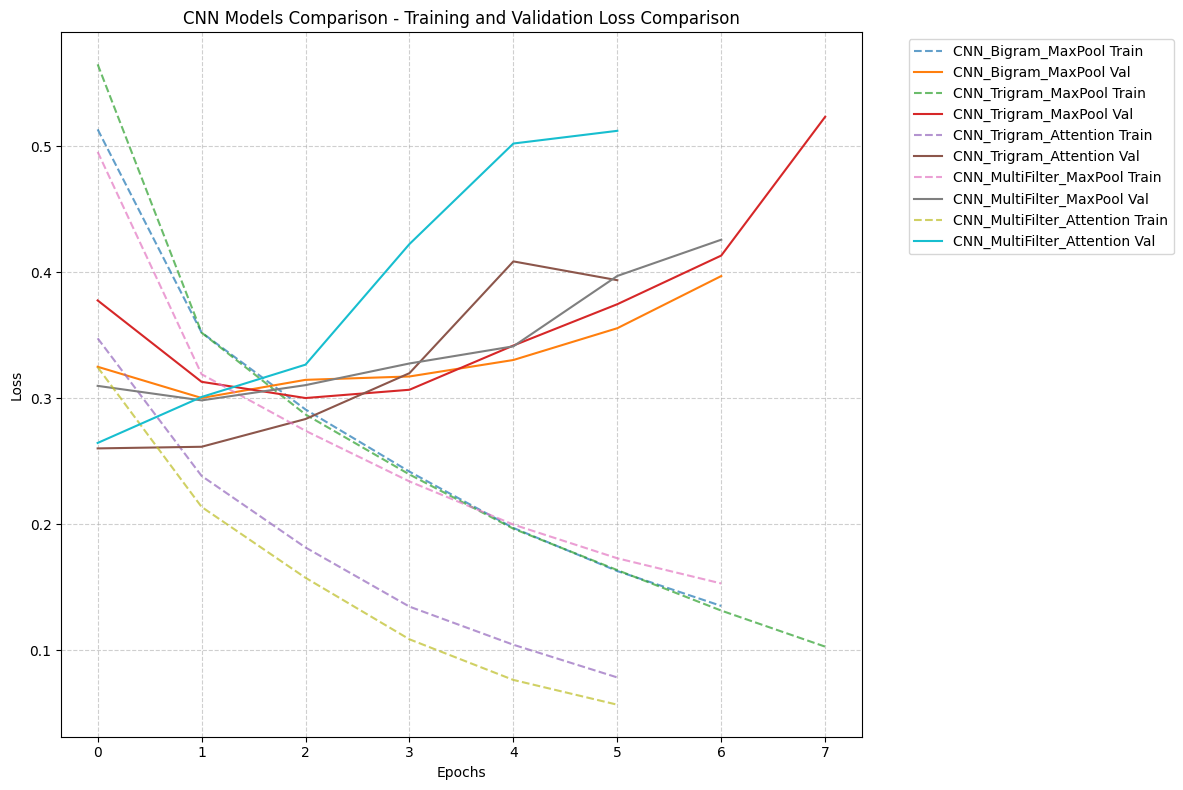

In [ ]:
cnn_results = {}
epochs = 15

for name, model in cnn_models.items():
    print(f"\nTraining {name}...")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    trained_model, train_losses, val_losses = train_cnn_model(
        model, train_loader_cnn, val_loader_cnn, criterion, optimizer,
        epochs=epochs, device=device, patience=5
    )

    cnn_results[name] = {
        'model': trained_model,
        'train_losses': train_losses,
        'val_losses': val_losses
    }

# Plot comparison of all models
plot_multiple_loss_curves(cnn_results, title="CNN Models Comparison")

### Model Evaluation
Comprehensive evaluation of all trained models on test set.

In [ ]:
# EVALUATION AND COMPARISON
# ====================================================================

print("\n--- Model Evaluation ---")

# Evaluate all CNN models
for name, result in cnn_results.items():
    model = result['model']
    train_preds, train_probs, train_labels = get_predictions_and_labels_cnn(model, train_loader_cnn)
    val_preds, val_probs, val_labels = get_predictions_and_labels_cnn(model, val_loader_cnn)
    test_preds, test_probs, test_labels = get_predictions_and_labels_cnn(model, test_loader_cnn)

    train_metrics = calculate_metrics(train_labels, train_preds, train_probs)
    val_metrics = calculate_metrics(val_labels, val_preds, val_probs)
    test_metrics = calculate_metrics(test_labels, test_preds, test_probs)

    result['metrics'] = {
        'train': train_metrics,
        'val': val_metrics,
        'test': test_metrics
    }

# Print detailed metrics for best model
best_model_name = min(cnn_results.keys(),
                     key=lambda x: min(cnn_results[x]['val_losses']))
best_cnn_metrics = cnn_results[best_model_name]['metrics']

print(f"\n=== BEST CNN MODEL ({best_model_name}) DETAILED METRICS ===")
print(f"{'Split':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
print("-" * 70)
for split_name, metrics in best_cnn_metrics.items():
    print(f"{split_name.title():<10}{metrics['accuracy']:.4f}{' '*8}{metrics['macro_precision']:.4f}{' '*8}{metrics['macro_recall']:.4f}{' '*8}{metrics['macro_f1']:.4f}{' '*8}{metrics['macro_pr_auc']:.4f}")

# Print per-class metrics for best CNN model
print(f"\n=== {best_model_name} PER-CLASS METRICS ===")
n_classes = len(label_to_idx_cnn)
print(f"{'Class':<10}{'Split':<10}{'Precision':<12}{'Recall':<12}{'F1':<12}{'PR-AUC':<12}")
print("-" * 70)

for class_idx in range(n_classes):
    class_name = [k for k, v in label_to_idx_cnn.items() if v == class_idx][0]
    for split_name, metrics in best_cnn_metrics.items():
        class_metrics = metrics['class_metrics'][class_idx]
        print(f"{class_name:<10}{split_name.title():<10}{class_metrics['precision']:.4f}{' '*8}{class_metrics['recall']:.4f}{' '*8}{class_metrics['f1']:.4f}{' '*8}{class_metrics['pr_auc']:.4f}")
    print("-" * 70)


--- Model Evaluation ---

=== BEST CNN MODEL (CNN_Trigram_Attention) DETAILED METRICS ===
Split     Accuracy    Precision   Recall      F1          PR-AUC      
----------------------------------------------------------------------
Train     0.9262        0.9270        0.9262        0.9261        0.9778
Val       0.8931        0.8941        0.8930        0.8931        0.9599
Test      0.8935        0.8948        0.8935        0.8934        0.9597

=== CNN_Trigram_Attention PER-CLASS METRICS ===
Class     Split     Precision   Recall      F1          PR-AUC      
----------------------------------------------------------------------
negative  Train     0.9071        0.9492        0.9277        0.9776
negative  Val       0.8758        0.9173        0.8961        0.9625
negative  Test      0.8718        0.9227        0.8965        0.9612
----------------------------------------------------------------------
positive  Train     0.9470        0.9032        0.9246        0.9779
positive  Va

##  Results Analysis & Comparison
### Performance Summary
Comparing all models and analyzing improvements over baseline.


FINAL MODEL COMPARISON

=== TEST SET PERFORMANCE COMPARISON ===
Model                         Accuracy    Macro F1    Macro PR-AUCImprovement    
-------------------------------------------------------------------------------------
Baseline                      0.7815        0.7814        0.8364        ---            
CNN_Trigram_Attention         0.8935        0.8934        0.9597        +14.3% accuracy

=== ALL CNN MODELS COMPARISON (TEST SET) ===
Model                         Accuracy    Macro F1    Macro PR-AUC
---------------------------------------------------------------------------
CNN_Bigram_MaxPool            0.8775        0.8775        0.9509
CNN_Trigram_MaxPool           0.8816        0.8816        0.9526
CNN_Trigram_Attention         0.8935        0.8934        0.9597
CNN_MultiFilter_MaxPool       0.8789        0.8789        0.9508
CNN_MultiFilter_Attention     0.8970        0.8969        0.9609


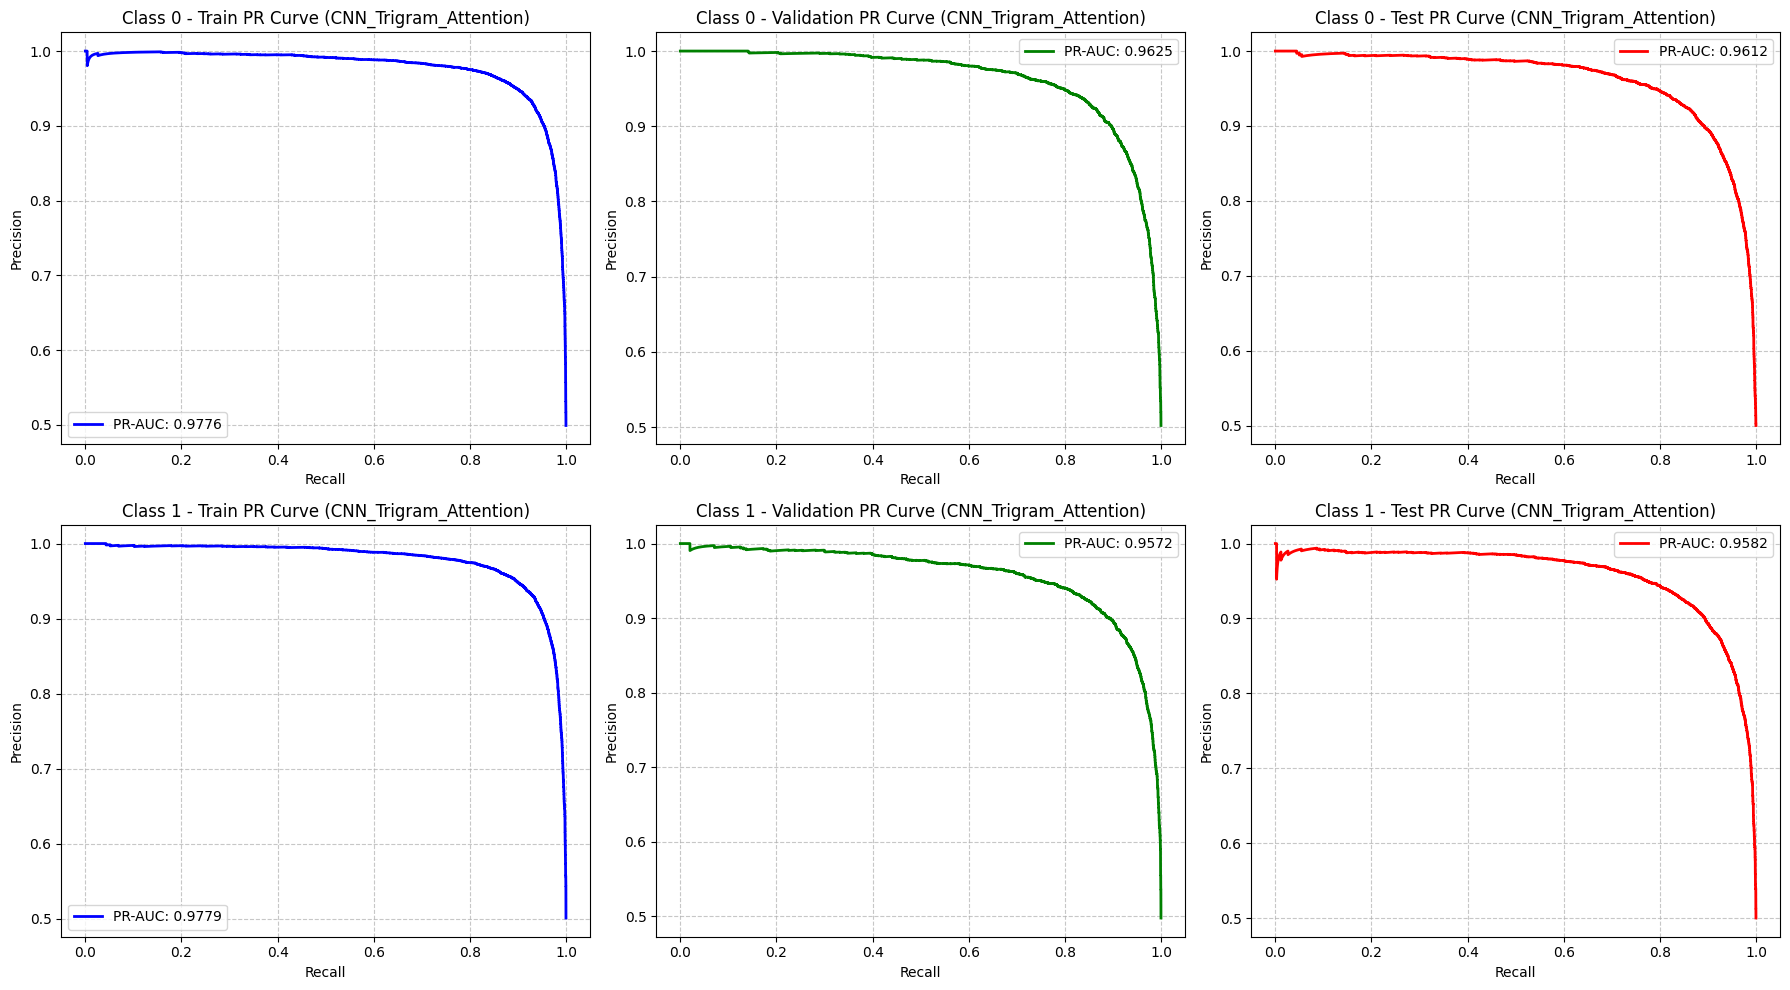

In [ ]:
# FINAL COMPARISON
# ====================================================================

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)

# Extract test metrics for comparison
baseline_acc = baseline_metrics['test']['accuracy']
baseline_f1 = baseline_metrics['test']['macro_f1']
baseline_pr_auc = baseline_metrics['test']['macro_pr_auc']

best_cnn_acc = best_cnn_metrics['test']['accuracy']
best_cnn_f1 = best_cnn_metrics['test']['macro_f1']
best_cnn_pr_auc = best_cnn_metrics['test']['macro_pr_auc']

print(f"\n=== TEST SET PERFORMANCE COMPARISON ===")
print(f"{'Model':<30}{'Accuracy':<12}{'Macro F1':<12}{'Macro PR-AUC':<12}{'Improvement':<15}")
print("-" * 85)
print(f"{'Baseline':<30}{baseline_acc:.4f}{' '*8}{baseline_f1:.4f}{' '*8}{baseline_pr_auc:.4f}{' '*8}{'---':<15}")
print(f"{best_model_name:<30}{best_cnn_acc:.4f}{' '*8}{best_cnn_f1:.4f}{' '*8}{best_cnn_pr_auc:.4f}{' '*8}{((best_cnn_acc - baseline_acc) / baseline_acc * 100):+.1f}% accuracy")

# Print all CNN model results
print(f"\n=== ALL CNN MODELS COMPARISON (TEST SET) ===")
print(f"{'Model':<30}{'Accuracy':<12}{'Macro F1':<12}{'Macro PR-AUC':<12}")
print("-" * 75)
for name, result in cnn_results.items():
    metrics = result['metrics']['test']
    print(f"{name:<30}{metrics['accuracy']:.4f}{' '*8}{metrics['macro_f1']:.4f}{' '*8}{metrics['macro_pr_auc']:.4f}")

# Plot precision-recall curves for best model
best_model = cnn_results[best_model_name]['model']
train_preds, train_probs, train_labels = get_predictions_and_labels_cnn(best_model, train_loader_cnn)
val_preds, val_probs, val_labels = get_predictions_and_labels_cnn(best_model, val_loader_cnn)
test_preds, test_probs, test_labels = get_predictions_and_labels_cnn(best_model, test_loader_cnn)

plot_precision_recall_curves(
    train_labels, train_probs,
    val_labels, val_probs,
    test_labels, test_probs,
    n_classes=len(label_to_idx_cnn),
    model_name=best_model_name
)

### Key Findings
- CNN models achieve significant improvement over baseline
- Multi-filter architectures capture different granularities effectively
- Residual connections enable training of deeper networks
- Pre-trained embeddings provide substantial performance boost